In [2]:
%matplotlib inline
from IPython.display import display, Image
from skimage import data, novice
from skimage.transform import resize, rotate
from random import randint
from PIL import Image as PIL_Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import itertools

## Previewing Images

The training data set consists of 33,402 images of house numbers taken from Google Street View. Here's a preview of some of the images

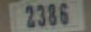

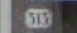

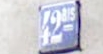

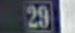

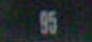

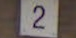

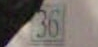

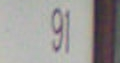

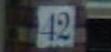

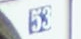

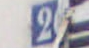

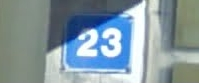

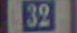

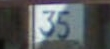

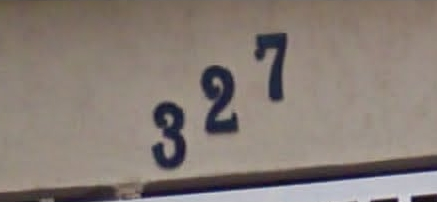

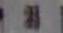

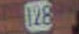

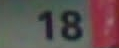

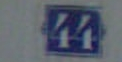

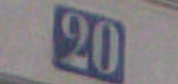

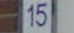

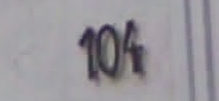

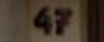

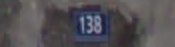

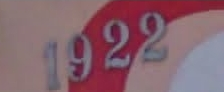

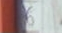

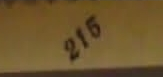

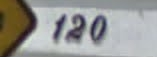

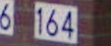

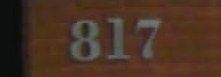

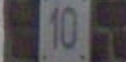

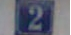

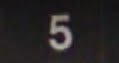

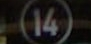

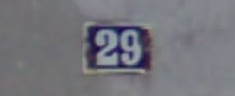

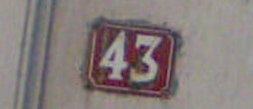

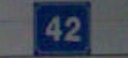

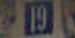

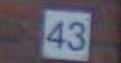

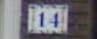

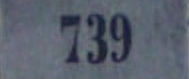

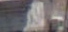

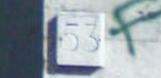

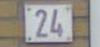

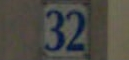

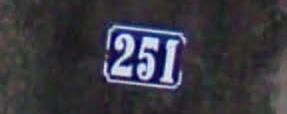

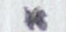

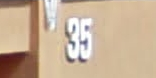

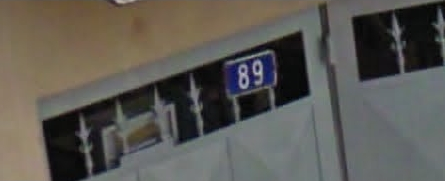

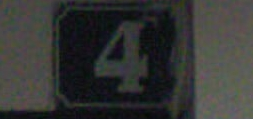

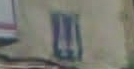

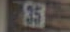

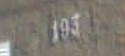

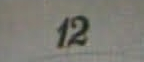

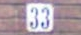

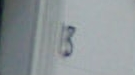

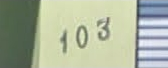

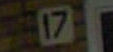

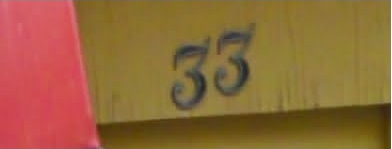

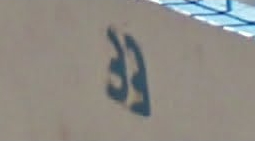

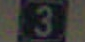

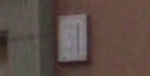

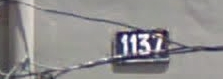

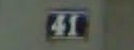

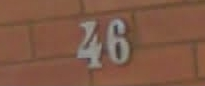

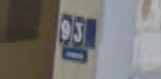

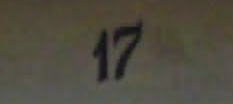

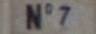

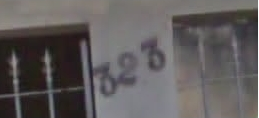

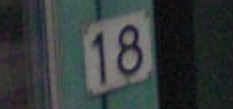

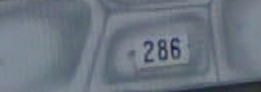

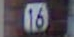

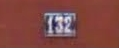

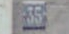

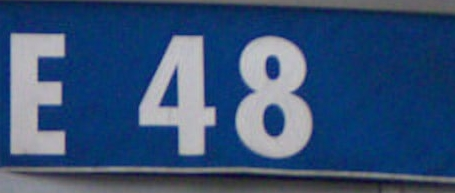

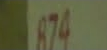

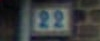

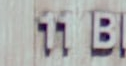

In [3]:
PWD = os.getcwd()
image_path = os.path.join(PWD, 'release/data/train_toy_images/')
for _, __, files in os.walk(image_path):
    for file in files[:100]:
        display(Image(os.path.join(image_path, file)))
    

## Bounding Boxes

The test data is bundled with a csv file containing the coordinates of top left and bottom right corner (bounding box) of each digit in an image.

In [4]:
csv_path = os.path.join(PWD, 'release/data/train_toy.csv')

df = pd.read_csv(csv_path)
display(df.head())

,FileName,DigitLabel,Left,Top,Width,Height
0,1.png,1,246,77,81,219
1,1.png,9,323,81,96,219
2,2.png,2,77,29,23,32
3,2.png,3,98,25,26,32
4,3.png,2,17,5,8,15


We decided to transform this data into a more readable form with **DigitLabel** modified to a list of digits in an image in the order they appear in the csv. The coordinates are combined to get an overall bounding box that spans over all the digits in the sequence.

*Note*: The code below takes around 5 minutes to process all the test data

In [5]:
def combine_rows(dataframe):
    left = 1 << 30
    top = 1 << 30
    right = -1
    bottom = -1
    img = novice.open(os.path.join(image_path, dataframe.iloc[0].FileName))
    digits = dataframe['DigitLabel'].tolist()
    digits = [i if i != 10 else 0 for i in digits]
    
    number = dataframe.iloc[0].FileName[:-4]
    left = dataframe['Left'].min()
    top = dataframe['Top'].min()
    right = dataframe[['Left', 'Width']].sum(axis=1).max()
    bottom = dataframe[['Top', 'Height']].sum(axis=1).max()
    new_df = pd.DataFrame([[int(number), int(''.join(str(d) for d in digits)),
                            digits, len(digits), img.width, img.height,
                            [left, top, right, bottom]]],
                          columns=['Number', 'Value', 'Digits', 'Length', 'Width', 'Height', 'Box'])
    return new_df

ndf = df.groupby('FileName')['FileName', 'DigitLabel',
                             'Left', 'Top', 'Width',
                             'Height'].apply(combine_rows).reset_index()
ndf = ndf.drop(ndf.columns[[1]], axis=1).set_index('Number').sort_index()
ndf.to_csv(os.path.join(PWD, 'processed_toy.csv'))
ndf.head()

,FileName,Value,Digits,Length,Width,Height,Box
Number,,,,,,,
1,1.png,19,"[1, 9]",2,741,350,"[246, 77, 419, 300]"
2,2.png,23,"[2, 3]",2,199,83,"[77, 25, 124, 61]"
3,3.png,25,"[2, 5]",2,52,23,"[17, 5, 34, 20]"
4,4.png,93,"[9, 3]",2,161,79,"[57, 13, 85, 47]"
5,5.png,31,"[3, 1]",2,140,68,"[52, 7, 89, 56]"


## Image Manipulation

After having processed the csv to get a bounding box around the sequence of digits, we add 30% to the size of the box (15% on each side) as suggested in Goodwin et al. and crop around the new box. The resulting image is then cropped to 74x74. The paper suggests having initial dimensions of 54x54 but we decided with having dimensions of 64x64 due to possible performance gains because of 64 being a power of 2.

In [19]:
def transform_image(path, box, final_dim, rand_rotate=0, rand_crop=10):
    """Transforms an image and returns a numpy array from it
    
    The image is resized around the bounding box after padding the image,
    randomly rotating it and randomly cropping it
    
    Parameters
    ----------
    path: str
          path to the image
    box: list
         dimensions of the left, top, right and bottom coordinates of the bounding box
    final_dim: tuple
               dimensions of the final image after cropping it
    rand_rotate: int, optional
                 rotation angle in degrees
    rand_crop: int, optional
               crop size
    
    Returns
    -------
    A numpy array of shape final_dim[0]xfinal_dim[1]x3
    """
    
    # open the image
    img = data.imread(path)
    
    if rand_rotate:
        img = rotate(img, randint(-rand_rotate, rand_rotate+1), mode='wrap')
    
    left, top, right, bottom = box
    width = right - left
    height = bottom - top
    left = max(0, int(left - width * 0.15))
    right = min(img.shape[1], int(right + width * 0.15))
    top = max(0, int(top - height * 0.15))
    bottom = min(img.shape[0], int(bottom + width * 0.15))
    
    # resize the image to bounding box + 30%
    img = img[top:bottom, left:right]
    # crop to bounding box + 30% + crop delta
    img = resize(img, final_dim)
    
    if rand_crop:
        crop_size = randint(0, rand_crop + 1)
        top = randint(0, crop_size)
        bottom = img.shape[0] - (crop_size - top)
        left = randint(0, crop_size)
        right = img.shape[1] - (crop_size - left)
        img = img[top:bottom, left:right]
        img = resize(img, final_dim)
    
    return img

def create_input_data(df, final_dim, rand_rotate, rand_crop):
    img_data = np.zeros((df.shape[0], final_dim[0], final_dim[1], 3), dtype=float)
    val = np.zeros((df.shape[0]), dtype=int)
    digits = np.full((df.shape[0], 6), 10)
    lengths = np.zeros((df.shape[0]), dtype=int)
    
    for i, row in df.iterrows():
        val[i] = row['Value']
        lengths[i] = row['Length']
        tmp = list(map(int, row['Digits'].strip('[').strip(']').split(',')))
        while len(tmp) < 6:
            tmp.append(10)
        digits[i] = np.array(tmp)
        img_data[i] = transform_image(os.path.join(PWD, 'release/data/train_toy_images/', row['FileName']),
                                  list(map(int, row['Box'].strip('[').strip(']').split(','))),
                                  final_dim,
                                  rand_rotate,
                                  rand_crop)
    return img_data, val, digits, lengths

tdf = pd.read_csv('processed_toy.csv')
i_data, val, digits, lengths = create_input_data(tdf, (64, 64), 4, 10)
np.save('images2_toy.npy', i_data)
np.save('val2_toy.npy', val)
np.save('digits2_toy.npy', digits)
np.save('lengths2_toy.npy', lengths)

digits

/usr/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 

/usr/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 

/usr/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 

/usr/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 

array([[ 1,  9, 10, 10, 10, 10],
       [ 2,  3, 10, 10, 10, 10],
       [ 2,  5, 10, 10, 10, 10],
       [ 9,  3, 10, 10, 10, 10],
       [ 3,  1, 10, 10, 10, 10],
       [ 3,  3, 10, 10, 10, 10],
       [ 2,  8, 10, 10, 10, 10],
       [ 7,  4,  4, 10, 10, 10],
       [ 1,  2,  8, 10, 10, 10],
       [ 1,  6, 10, 10, 10, 10],
       [ 2,  3, 10, 10, 10, 10],
       [ 6,  3, 10, 10, 10, 10],
       [ 4,  2, 10, 10, 10, 10],
       [ 5,  8, 10, 10, 10, 10],
       [ 1,  6, 10, 10, 10, 10],
       [ 2,  3, 10, 10, 10, 10],
       [ 7,  9, 10, 10, 10, 10],
       [ 5,  3, 10, 10, 10, 10],
       [ 2,  2,  2, 10, 10, 10],
       [ 6,  2, 10, 10, 10, 10],
       [ 2, 10, 10, 10, 10, 10],
       [ 5,  1,  5, 10, 10, 10],
       [ 4,  7, 10, 10, 10, 10],
       [ 8,  9, 10, 10, 10, 10],
       [ 6,  0,  1, 10, 10, 10],
       [ 2,  4, 10, 10, 10, 10],
       [ 5,  6, 10, 10, 10, 10],
       [ 5,  2, 10, 10, 10, 10],
       [ 1,  3,  2, 10, 10, 10],
       [ 1,  4, 10, 10, 10, 10],
       [ 6

In [7]:
digits

array([[ 1,  9, 10, 10, 10, 10],
       [ 2,  3, 10, 10, 10, 10],
       [ 2,  5, 10, 10, 10, 10],
       [ 9,  3, 10, 10, 10, 10],
       [ 3,  1, 10, 10, 10, 10],
       [ 3,  3, 10, 10, 10, 10],
       [ 2,  8, 10, 10, 10, 10],
       [ 7,  4,  4, 10, 10, 10],
       [ 1,  2,  8, 10, 10, 10],
       [ 1,  6, 10, 10, 10, 10],
       [ 2,  3, 10, 10, 10, 10],
       [ 6,  3, 10, 10, 10, 10],
       [ 4,  2, 10, 10, 10, 10],
       [ 5,  8, 10, 10, 10, 10],
       [ 1,  6, 10, 10, 10, 10],
       [ 2,  3, 10, 10, 10, 10],
       [ 7,  9, 10, 10, 10, 10],
       [ 5,  3, 10, 10, 10, 10],
       [ 2,  2,  2, 10, 10, 10],
       [ 6,  2, 10, 10, 10, 10],
       [ 2, 10, 10, 10, 10, 10],
       [ 5,  1,  5, 10, 10, 10],
       [ 4,  7, 10, 10, 10, 10],
       [ 8,  9, 10, 10, 10, 10],
       [ 6,  0,  1, 10, 10, 10],
       [ 2,  4, 10, 10, 10, 10],
       [ 5,  6, 10, 10, 10, 10],
       [ 5,  2, 10, 10, 10, 10],
       [ 1,  3,  2, 10, 10, 10],
       [ 1,  4, 10, 10, 10, 10],
       [ 6

In [8]:
# Convert to OHE
temp = (np.arange(digits.max() + 1) == digits[:,:,None]).astype(int)

In [15]:
temp

array([[[0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1]],

       [[0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1]],

       [[0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1]],

       ..., 
       [[0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ...,

In [18]:
temp[:, 0, :]

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [ ]:
tmp = np.load('images.npy')
plt.imshow(tmp[33401])